<a href="https://colab.research.google.com/github/Nouha50215/NLP-Assignment-1/blob/main/Nlp_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install & import sentiment tools

In [19]:
pip install nltk textblob vaderSentiment

Import Required Libraries

In [20]:
import kagglehub
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Download

In [21]:
# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


Load the data

In [22]:
# Load CSV file
data = pd.read_csv(f"{path}/IMDB Dataset.csv")
# Display first rows
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Missing values:
 review       0
sentiment    0
dtype: int64

Duplicate rows: 418

Class distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


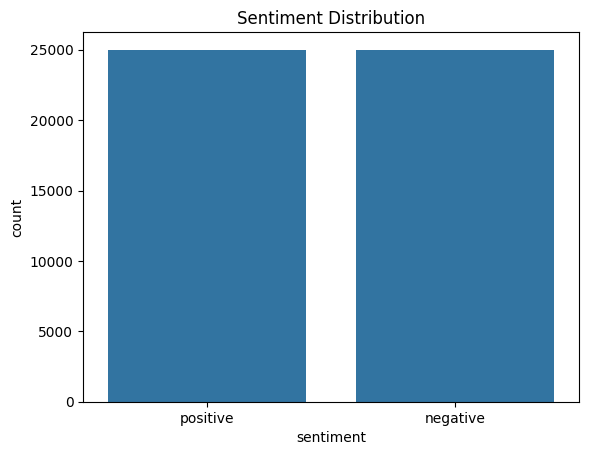

In [23]:
# Dataset information
print(data.info())

# Check missing values
print("\nMissing values:\n", data.isnull().sum())

# Check duplicate rows
print("\nDuplicate rows:", data.duplicated().sum())

# Class distribution
print("\nClass distribution:\n", data["sentiment"].value_counts())

# Visualization
sns.countplot(x="sentiment", data=data)
plt.title("Sentiment Distribution")
plt.show()

Text Preprocessing
 Basic cleaning: lowercase, remove HTML tags, remove extra spaces

In [24]:
def clean_text(text):
    text = text.lower()                         # convert to lowercase
    text = re.sub(r"<.*?>", "", text)           # remove HTML tags
    text = re.sub(r"\s+", " ", text)            # remove extra spaces
    return text.strip()

# Apply cleaning
data["clean_review"] = data["review"].apply(clean_text)
data.head() # Display first row

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is..."


Feature Engineering
 Using Sentence-Level Polarity Features
 VADER (Valence Aware Dictionary and sEntiment Reasoner) + TextBlob (Hybrid Approach)

In [25]:
# Download VADER lexicon
nltk.download("vader_lexicon")
# Initialize VADER
vader = SentimentIntensityAnalyzer()

def extract_features(text): # takes one review and returns 5 numerical values.
    """
    Extracts:
    - VADER negative score
    - VADER neutral score
    - VADER positive score
    - VADER compound score
    - TextBlob polarity
    """
    # compute sentiment scores
    vader_scores = vader.polarity_scores(text)
    # TextBlob returns a single number, polarity between -1 and +1
    blob_polarity = TextBlob(text).sentiment.polarity

    # Returning the feature vector
    return [
        vader_scores["neg"],
        vader_scores["neu"],
        vader_scores["pos"],
        vader_scores["compound"],
        blob_polarity
    ]

# Convert reviews into feature matrix
X = np.array([extract_features(text) for text in data["clean_review"]])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Label Encoding
 0 = negative
 1 = positive

In [26]:
data["label"] = data["sentiment"].map({"positive": 1, "negative": 0})
y = data["label"].values
data.head()

,review,sentiment,clean_review,label
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. the filming tec...,1
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is...",1


Train / Validation / Test Split
 60% Train
 20% Validation
 20% Test

In [27]:
# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train + validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

Build Multi-Layer Perceptron (MLP) Model
 - Hidden layers use ReLU
 - Output layer uses Sigmoid (handled automatically)
 - Loss: Binary Cross-Entropy (log loss)

In [28]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # two hidden layers
    activation="relu",            # ReLU activation
    solver="adam",                # gradient descent optimization
    max_iter=100,                 # training iterations
    random_state=42
)

# Train model
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)

Plot Training Loss Curve

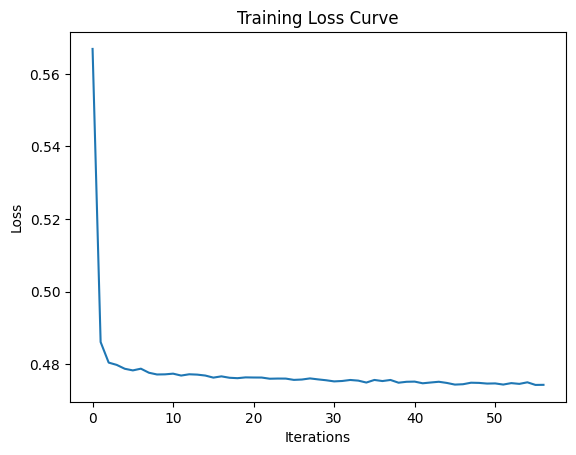

In [29]:
plt.plot(mlp.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

Validation Evaluation

In [30]:
val_pred = mlp.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))

Validation Accuracy: 0.7752


Final Test Evaluation

In [31]:
# Get probabilities
y_prob = mlp.predict_proba(X_test)[:, 1]

# Apply threshold 0.5
y_pred = (y_prob >= 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7742

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78      5000
           1       0.79      0.75      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Confusion Matrix

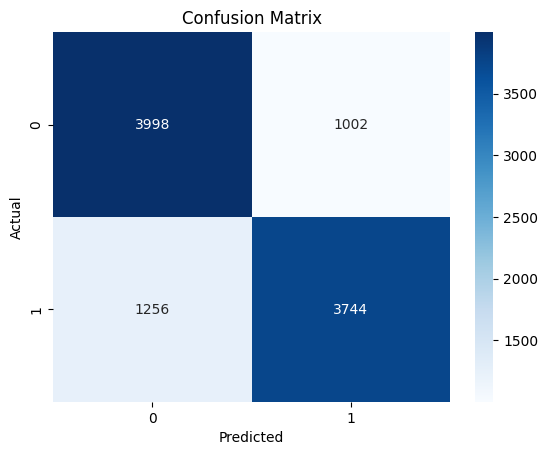

In [32]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Save Model

In [33]:
joblib.dump(mlp, "mlp_sentiment_model.pkl")

print("Model saved successfully.")

Model saved successfully.


Download files

In [35]:
from google.colab import files

files.download("mlp_sentiment_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>